# Gesture Recognition Case study
#### By- Jeeva Thangaraj
####        Nitesh Kumar Singh

### Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

Each video is a sequence of 30 frames (or images).

In [77]:
# Importing the necessary libraries
import numpy as np
import datetime
import os
import cv2
import random as rn
import tensorflow as tf
from keras import backend as K

In [78]:
import matplotlib.pyplot as plt
% matplotlib inline

In [79]:
# importing some other libraries which will be needed for model building.
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization
from keras.layers import Activation, Dropout, ZeroPadding3D
from keras.layers.convolutional import Conv2D, MaxPooling3D, Conv3D, MaxPooling2D
from keras.layers.recurrent import LSTM

In [80]:
np.random.seed(30)
rn.seed(30)
tf.set_random_seed(30)
train_path = './Project_data/train'
val_path = './Project_data/val'
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
batch_size = 10 #experiment with the batch size

In [81]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 10 #experiment with the batch size

In [82]:
# Parameters initialization
nb_rows = 120   # X dimension of the image
nb_cols = 120   # Y dimesnion of the image
total_frames = 30
nb_frames = 30  # lenght of the video frames
nb_channel = 3 # numbe rof channels in images 3 for color(RGB) and 1 for Gray

## Generator
This is one of the most important part of the code. The overall structure of the generator is broken down into modules. In the generator, we are going to preprocess the images as we have images of 2 different dimensions as well as create a batch of video frames. 

In [83]:
def get_random_affine():
    dx, dy = np.random.randint(-1.7, 1.8, 2)
    M = np.float32([[1, 0, dx], [0, 1, dy]])
    return M

In [84]:
def init_batch_data(batch_size):
    batch_data = np.zeros((batch_size, nb_frames, nb_rows, nb_cols, nb_channel)) 
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
    return batch_data, batch_labels

In [85]:
def load_batch_images(source_path, folder_list, batch_num, batch_size, t,validation):
    
    batch_data,batch_labels = init_batch_data(batch_size)
    
    # We will also build an augumented batch data with affine transformation
    batch_data_aug,batch_labels_aug = init_batch_data(batch_size)
    
    # We will also build an augmented batch data with horizontal flip
    batch_data_flip,batch_labels_flip = init_batch_data(batch_size)
    
    #create a list of image numbers you want to use for a particular video using full frames
    img_idx = [x for x in range(0, nb_frames)] 

    for folder in range(batch_size): # iterate over the batch_size
        # read all the images in the folder
        imgs = sorted(os.listdir(source_path+'/'+ t[folder + (batch_num*batch_size)].split(';')[0])) 
        # Generate a random affine to be used in image transformation for buidling agumented data set
        M = get_random_affine()
        
        #  Iterate over the frames/images of a folder to read them in
        for idx, item in enumerate(img_idx): 
            ## image = imread(source_path+'/'+ t[folder + (batch_num*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
            image = cv2.imread(source_path+'/'+ t[folder + (batch_num*batch_size)].strip().split(';')[0]+'/'+imgs[item], cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Cropping non symmetric frames
            if image.shape[0] != image.shape[1]:
                image=image[0:120,20:140]
            
            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes   
            resized = cv2.resize(image, (nb_rows,nb_cols), interpolation = cv2.INTER_AREA)
            #Normal data
            batch_data[folder,idx] = (resized)
            
            #Data with affine transformation
            batch_data_aug[folder,idx] = (cv2.warpAffine(resized, M, (resized.shape[0], resized.shape[1])))
            
            # Data with horizontal flip
            batch_data_flip[folder,idx]= np.flip(resized,1)

        batch_labels[folder, int(t[folder + (batch_num*batch_size)].strip().split(';')[2])] = 1
        batch_labels_aug[folder, int(t[folder + (batch_num*batch_size)].strip().split(';')[2])] = 1
        
        # Labeling data with horizobtal flip, right swipe becomes left swipe and viceversa
        if int(t[folder + (batch_num*batch_size)].strip().split(';')[2])==0:
                    batch_labels_flip[folder, 1] = 1
        elif int(t[folder + (batch_num*batch_size)].strip().split(';')[2])==1:
                    batch_labels_flip[folder, 0] = 1
                    
        else:
                    batch_labels_flip[folder, int(t[folder + (batch_num*batch_size)].strip().split(';')[2])] = 1
                  
    
    batch_data_final = np.append(batch_data, batch_data_aug, axis = 0)
    batch_data_final = np.append(batch_data_final, batch_data_flip, axis = 0)

    batch_labels_final = np.append(batch_labels, batch_labels_aug, axis = 0) 
    batch_labels_final = np.append(batch_labels_final, batch_labels_flip, axis = 0)
    
    if validation:
        batch_data_final=batch_data
        batch_labels_final= batch_labels
        
    return batch_data_final,batch_labels_final

In [86]:
def generator(source_path, folder_list, batch_size, validation=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            # you yield the batch_data and the batch_labels, remember what does yield do
            yield load_batch_images(source_path, folder_list, batch, batch_size, t,validation)
            

        
        # Code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            yield load_batch_images(source_path, folder_list, batch, batch_size, t,validation)



# Helper function to flip the image
def __flip(self, image):
        return np.flip(image,1)
    
# Helper function to normalise the data
def __normalize(self, image):
        return image/127.5-1
    
# Helper function to resize the image
def __resize(self, image):
        return cv2.resize(image, (self.width,self.height), interpolation = cv2.INTER_AREA)
    
# Helper function to crop the image
def __crop(self, image):
    if image.shape[0] != image.shape[1]:
        return image[0:120, 20:140]
    else:
        return image

In [87]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Final Model

In [88]:
nb_filters = [8,16,32,64]
nb_dense = [256, 128, 5]

# Input
input_shape=(nb_frames,nb_rows,nb_cols,nb_channel)

# Define model
model = Sequential()

model.add(Conv3D(nb_filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(nb_dense[0], activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(nb_dense[1], activation='relu'))
model.add(Dropout(0.25))

#softmax layer
model.add(Dense(nb_dense[2], activation='softmax'))

In [89]:
optimiser = Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_10 (Batc (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_13 (Activation)   (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_11 (Batc (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_14 (Activation)   (None, 15, 60, 60, 16)    0         
__________

In [90]:
train_generator = generator(train_path, train_doc,batch_size=10)
val_generator = generator(val_path, val_doc, batch_size=10,validation=True)

In [91]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the Reducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

In [92]:
num_train_sequences//10

66

In [93]:
num_val_sequences/10

10.0

In [96]:
batch_size = 20
num_epochs = 30

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [97]:
model_history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
34/34 [==============================] - 49s 1s/step - loss: 1.4373 - categorical_accuracy: 0.3667 - val_loss: 1.8378 - val_categorical_accuracy: 0.3600

Epoch 00001: saving model to model_init_2020-11-0915_09_01.811273/model-00001-1.43731-0.36667-1.83779-0.36000.h5
Epoch 2/30
34/34 [==============================] - 26s 753ms/step - loss: 1.2313 - categorical_accuracy: 0.4946 - val_loss: 1.3645 - val_categorical_accuracy: 0.4800

Epoch 00002: saving model to model_init_2020-11-0915_09_01.811273/model-00002-1.20032-0.49833-1.36447-0.48000.h5
Epoch 3/30
34/34 [==============================] - 14s 425ms/step - loss: 1.2417 - categorical_accuracy: 0.5425 - val_loss: 1.3695 - val_categorical_accuracy: 0.4800

Epoch 00003: saving model to model_init_2020-11-0915_09_01.811273/model-00003-1.24169-0.54248-1.36947-0.48000.h5
Epoch 4/30
34/34 [==============================] - 15s 446ms/step - loss: 1.2912 - categorical_accuracy: 0.4379 - val_loss: 1.1453 - val_categorical_accuracy: 

In [98]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

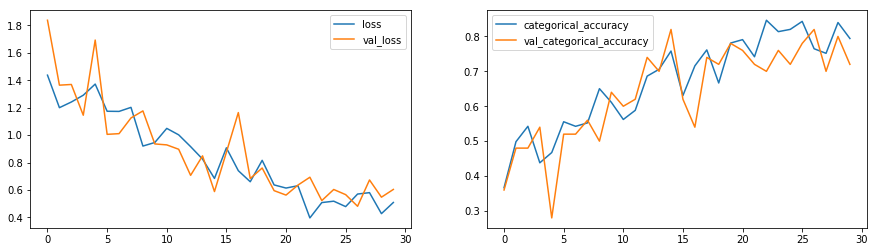

In [99]:
plot(model_history)

__The best weights of model is on epoch 29/30 : model-00029-0.42772-0.83987-0.54774-0.80000.h5 . 
